In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

project_path = '/content/drive/MyDrive/stock_price'
os.chdir(project_path)

# Verify
!ls

 alpha_earnings_calls.csv	 best_model.pth
 alpha_economic_indicators.csv	 data
 alpha_stock_prices.csv		 merged_news_stock.csv
 alpha_ticker_news.csv		'merged_news_stock(finbert).csv'
 alpha_topic_news.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
import os

In [ ]:
# -----------------------------
# config
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sequence_length = 10
batch_size = 64
num_epochs = 100
patience = 10  # EarlyStopping patience
model_save_path = 'best_model.pth'

In [ ]:
# -----------------------------
# load data
# -----------------------------
stock_df =  pd.read_csv("merged_news_stock(finbert).csv")

# ensure sort by ticker and date
stock_df['date'] = pd.to_datetime(stock_df['date'])
stock_df = stock_df.sort_values(by=['ticker', 'date']).reset_index(drop=True)

In [ ]:
stock_df.head()

,ticker,title,summary,sentiment,score,date,open,high,low,close,volume,finbert_score
0,AAPL,"""R-Word"" Fears Send Stock Market Much Lower",While the tech-heavy Nasdaq and small-cap Russ...,Neutral,-0.031339,2025-03-10,235.540,236.1600,224.22,227.48,71451281,-0.970833
1,AAPL,The Reality of Trump's Tariffs,"In this podcast, Motley Fool analyst Jason Mos...",Somewhat-Bullish,0.190336,2025-03-10,235.540,236.1600,224.22,227.48,71451281,-0.907352
2,AAPL,"Nasdaq Sell-Off: The 3 Best ""Magnificent Seven...","The Nasdaq has entered correction territory, a...",Somewhat-Bullish,0.245530,2025-03-11,223.805,225.8399,217.45,220.84,76137410,-0.666903
3,AAPL,"Hedges Become Profitable, Trump Stock Market P...","To gain an edge, this is what you need to know...",Somewhat-Bullish,0.182966,2025-03-11,223.805,225.8399,217.45,220.84,76137410,-0.838499
4,AAPL,Meta Taps Taiwan Semiconductor To Build AI Chi...,Meta is testing its first AI training chip to ...,Somewhat-Bullish,0.183252,2025-03-11,223.805,225.8399,217.45,220.84,76137410,0.558721


In [ ]:
import plotly.express as px

# Create the line chart using Plotly Express
fig = px.line(stock_df, x='date', y='close', title='Daily Close Price')

# Update the x-axis format to 'aaaa/mm/dd'
fig.update_xaxes(
    tickformat='%Y/%m/%d'  # Using %Y for four-digit year
)

# Display the chart
fig.show()


In [ ]:

# Select data for MSFT
msft_data = stock_df[stock_df['ticker'] == 'MSFT']

import plotly.express as px

# Create the line chart using Plotly Express
fig = px.line(msft_data, x='date', y='close', title='MSFT Daily Close Price')

# Update the x-axis format to 'aaaa/mm/dd'
fig.update_xaxes(
    tickformat='%Y/%m/%d'  # Using %Y for four-digit year
)

# Display the chart
fig.show()

In [ ]:
# -----------------------------
# Normalization
# -----------------------------

# Shift 'close' to create target (next day's close)
stock_df['next_close'] = stock_df.groupby('ticker')['close'].shift(-1)

# Drop the last row for each ticker (where target is NaN)
stock_df = stock_df.groupby('ticker').apply(lambda x: x[:-1]).reset_index(drop=True)

# Now proceed with normalization & train-test split
feature_cols = ['open', 'high', 'low', 'close','finbert_score']
target_col = 'next_close' # Tomorrow's closing price


# Normalize features (MinMax for prices,  FinBERT is already -1 to +1)
scaler_features = MinMaxScaler()
stock_df[['open', 'high', 'low', 'close']] = scaler_features.fit_transform(stock_df[['open', 'high', 'low', 'close']])

# Scale target separately
scaler_target = MinMaxScaler()
stock_df[[target_col]] = scaler_target.fit_transform(stock_df[[target_col]])
stock_df.head()



<ipython-input-72-b9995e894379>:9: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,ticker,title,summary,sentiment,score,date,open,high,low,close,volume,finbert_score,next_close
0,AAPL,"""R-Word"" Fears Send Stock Market Much Lower",While the tech-heavy Nasdaq and small-cap Russ...,Neutral,-0.031339,2025-03-10,0.199791,0.193695,0.194120,0.190892,71451281,-0.970833,0.190149
1,AAPL,The Reality of Trump's Tariffs,"In this podcast, Motley Fool analyst Jason Mos...",Somewhat-Bullish,0.190336,2025-03-10,0.199791,0.193695,0.194120,0.190892,71451281,-0.907352,0.184446
2,AAPL,"Nasdaq Sell-Off: The 3 Best ""Magnificent Seven...","The Nasdaq has entered correction territory, a...",Somewhat-Bullish,0.245530,2025-03-11,0.189643,0.185044,0.188143,0.185194,76137410,-0.666903,0.184446
3,AAPL,"Hedges Become Profitable, Trump Stock Market P...","To gain an edge, this is what you need to know...",Somewhat-Bullish,0.182966,2025-03-11,0.189643,0.185044,0.188143,0.185194,76137410,-0.838499,0.184446
4,AAPL,Meta Taps Taiwan Semiconductor To Build AI Chi...,Meta is testing its first AI training chip to ...,Somewhat-Bullish,0.183252,2025-03-11,0.189643,0.185044,0.188143,0.185194,76137410,0.558721,0.184446


In [ ]:
# Select data for MSFT
msft_data = stock_df[stock_df['ticker'] == 'MSFT']
msft_data.head()

,ticker,title,summary,sentiment,score,date,open,high,low,close,volume,finbert_score,next_close
8925,MSFT,Inside OpenAI's Massive $40B Funding Round Led...,OpenAI's valuation has climbed to $300 billion...,Somewhat-Bullish,0.321244,2025-03-31,0.318257,0.311808,0.32039,0.317813,35184676,0.946877,0.317532
8926,MSFT,Navigating Investment in Uncertain Markets,"We discuss market uncertainty, dollar-cost ave...",Somewhat-Bullish,0.225265,2025-03-31,0.318257,0.311808,0.32039,0.317813,35184676,-0.938022,0.317532
8927,MSFT,Microsoft ( MSFT ) Stock Sinks As Market Gai...,"In the closing of the recent trading day, Micr...",Somewhat-Bullish,0.172630,2025-03-31,0.318257,0.311808,0.32039,0.317813,35184676,0.537297,0.317532
8928,MSFT,CoreWeave Shares Are Trading Lower Today: What...,CoreWeave shares trade lower as investors reac...,Neutral,0.114821,2025-03-31,0.318257,0.311808,0.32039,0.317813,35184676,-0.964507,0.317532
8929,MSFT,"Top Stock Picks for Week of March 31, 2025",A medical info systems stock with a positive e...,Somewhat-Bullish,0.240616,2025-03-31,0.318257,0.311808,0.32039,0.317813,35184676,0.917309,0.317532


In [ ]:

# Select data for MSFT
msft_data = stock_df[stock_df['ticker'] == 'MSFT']

import plotly.express as px

# Create the line chart using Plotly Express
fig = px.line(msft_data, x='date', y='close', title='MSFT Daily Close Price')

# Update the x-axis format to 'aaaa/mm/dd'
fig.update_xaxes(
    tickformat='%Y/%m/%d'  # Using %Y for four-digit year
)

# Display the chart
fig.show()


In [ ]:
config = {
    "data": {
            "window_size": 20,
            "train_split_size": 0.80,
            "save_path": "data/price.csv"

        },
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_test": "#FF4136",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    }

}

<ipython-input-44-6ac107c9310f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



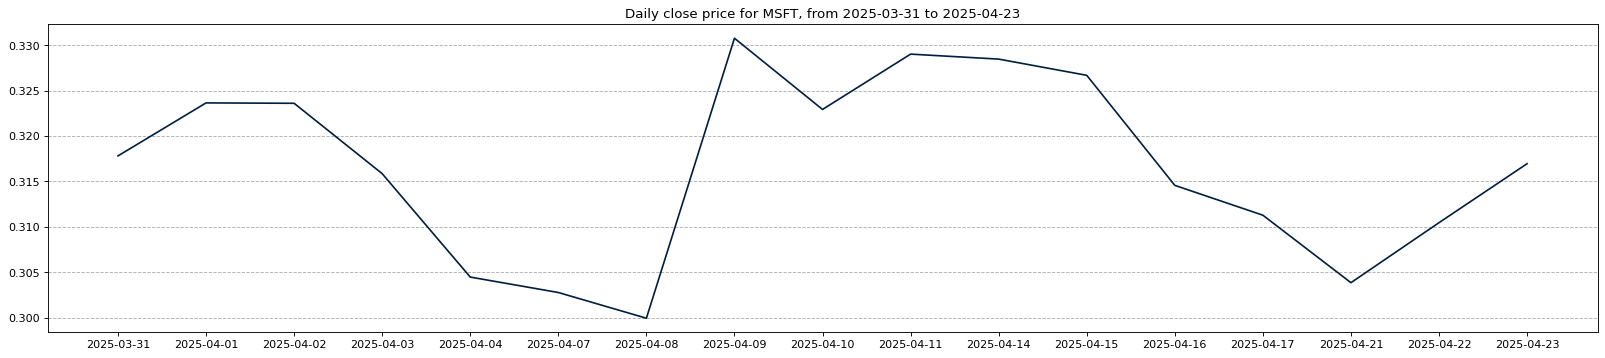

In [ ]:

from matplotlib.pyplot import figure

msft_data = stock_df[stock_df['ticker'] == 'MSFT']
msft_data['date'] = pd.to_datetime(msft_data['date']).dt.strftime('%Y-%m-%d')

date = msft_data['date'].tolist()
close = msft_data['close'].values
num_data_points = len(date)
display_date_range = "from " + date[0] + " to " + date[num_data_points-1]


fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(date, close, color=config["plots"]["color_actual"])
# xticks = [date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
# x = np.arange(0,len(xticks))
# plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + "MSFT" + ", " + display_date_range)
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.show()


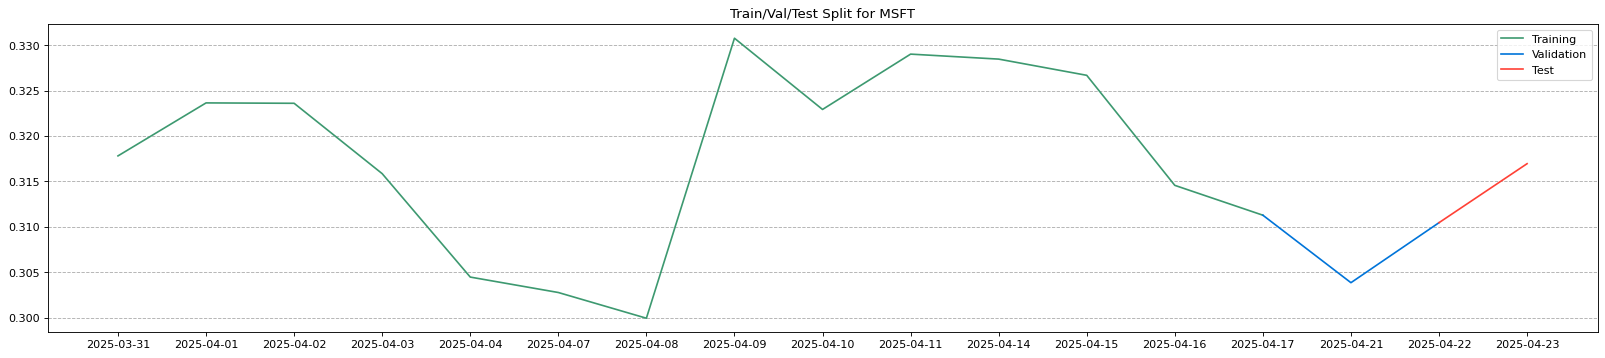

In [ ]:
 # Convert to numpy arrays for easier splitting
dates = np.array(date)
prices = np.array(close)

# Calculate split indices
num_samples = len(dates)
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)



# Split into train, validation, test
data_x_train = dates[:train_size]
data_y_train = prices[:train_size]

data_x_val = dates[train_size : train_size + val_size]
data_y_val = prices[train_size : train_size + val_size]

data_x_test = dates[train_size + val_size :]
data_y_test = prices[train_size + val_size :]



# Split into train, validation, test
train_dates = dates[:train_size]
train_prices = prices[:train_size]

val_dates = dates[train_size : train_size + val_size]
val_prices = prices[train_size : train_size + val_size]

test_dates = dates[train_size + val_size :]
test_prices = prices[train_size + val_size :]

# Plot with different colors
plt.figure(figsize=(25, 5), dpi=80)
plt.plot(train_dates, train_prices, color=config["plots"]["color_train"], label="Training")
plt.plot(val_dates, val_prices, color=config["plots"]["color_val"], label="Validation")
plt.plot(test_dates, test_prices, color=config["plots"]["color_test"], label="Test")


plt.title(f"Train/Val/Test Split for MSFT")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

In [ ]:
# -----------------------------
# sliding window Dataset
# -----------------------------
class SlidingWindowDataset(Dataset):
    def __init__(self, df, sequence_length, feature_cols, target_col):
        self.sequence_length = sequence_length
        self.feature_cols = feature_cols
        self.target_col = target_col

        self.X, self.y = self.create_sequences(df)

    def create_sequences(self, df):
        X = []
        y = []
        data = df[self.feature_cols].values
        target = df[self.target_col].values

        for i in range(len(data) - self.sequence_length):
            X.append(data[i:i+self.sequence_length])
            y.append(target[i+self.sequence_length])

        return np.array(X), np.array(y).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [ ]:
# -----------------------------
# divide train / val / test by time
# -----------------------------
train_data = stock_df.groupby('ticker').apply(lambda x: x.iloc[:int(0.7 * len(x))]).reset_index(drop=True)
val_data = stock_df.groupby('ticker').apply(lambda x: x.iloc[int(0.7 * len(x)):int(0.85 * len(x))]).reset_index(drop=True)
test_data = stock_df.groupby('ticker').apply(lambda x: x.iloc[int(0.85 * len(x)):]).reset_index(drop=True)



<ipython-input-73-b2b7a3b61c6d>:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-73-b2b7a3b61c6d>:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-73-b2b7a3b61c6d>:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `i

In [ ]:
train_data.head()

,ticker,title,summary,sentiment,score,date,open,high,low,close,volume,finbert_score,next_close
0,AAPL,"""R-Word"" Fears Send Stock Market Much Lower",While the tech-heavy Nasdaq and small-cap Russ...,Neutral,-0.031339,2025-03-10,0.199791,0.193695,0.194120,0.190892,71451281,-0.970833,0.190149
1,AAPL,The Reality of Trump's Tariffs,"In this podcast, Motley Fool analyst Jason Mos...",Somewhat-Bullish,0.190336,2025-03-10,0.199791,0.193695,0.194120,0.190892,71451281,-0.907352,0.184446
2,AAPL,"Nasdaq Sell-Off: The 3 Best ""Magnificent Seven...","The Nasdaq has entered correction territory, a...",Somewhat-Bullish,0.245530,2025-03-11,0.189643,0.185044,0.188143,0.185194,76137410,-0.666903,0.184446
3,AAPL,"Hedges Become Profitable, Trump Stock Market P...","To gain an edge, this is what you need to know...",Somewhat-Bullish,0.182966,2025-03-11,0.189643,0.185044,0.188143,0.185194,76137410,-0.838499,0.184446
4,AAPL,Meta Taps Taiwan Semiconductor To Build AI Chi...,Meta is testing its first AI training chip to ...,Somewhat-Bullish,0.183252,2025-03-11,0.189643,0.185044,0.188143,0.185194,76137410,0.558721,0.184446


In [ ]:
feature_cols,target_col, sequence_length

(['open', 'high', 'low', 'close', 'finbert_score'], 'next_close', 10)

In [ ]:
train_data.head()

,ticker,title,summary,sentiment,score,date,open,high,low,close,volume,finbert_score,next_close
0,AAPL,"""R-Word"" Fears Send Stock Market Much Lower",While the tech-heavy Nasdaq and small-cap Russ...,Neutral,-0.031339,2025-03-10,0.199791,0.193695,0.194120,0.190892,71451281,-0.970833,0.190559
1,AAPL,The Reality of Trump's Tariffs,"In this podcast, Motley Fool analyst Jason Mos...",Somewhat-Bullish,0.190336,2025-03-10,0.199791,0.193695,0.194120,0.190892,71451281,-0.907352,0.184859
2,AAPL,"Nasdaq Sell-Off: The 3 Best ""Magnificent Seven...","The Nasdaq has entered correction territory, a...",Somewhat-Bullish,0.245530,2025-03-11,0.189643,0.185044,0.188143,0.185194,76137410,-0.666903,0.184859
3,AAPL,"Hedges Become Profitable, Trump Stock Market P...","To gain an edge, this is what you need to know...",Somewhat-Bullish,0.182966,2025-03-11,0.189643,0.185044,0.188143,0.185194,76137410,-0.838499,0.184859
4,AAPL,Meta Taps Taiwan Semiconductor To Build AI Chi...,Meta is testing its first AI training chip to ...,Somewhat-Bullish,0.183252,2025-03-11,0.189643,0.185044,0.188143,0.185194,76137410,0.558721,0.184859


In [ ]:
train_dataset = SlidingWindowDataset(train_data, sequence_length, feature_cols, target_col)
val_dataset = SlidingWindowDataset(val_data, sequence_length, feature_cols, target_col)
test_dataset = SlidingWindowDataset(test_data, sequence_length, feature_cols, target_col)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
val_data.tail()

,ticker,title,summary,sentiment,score,date,open,high,low,close,volume,finbert_score,next_close
2449,XOM,US Stock Likely To Open Lower Following Trump'...,U.S. stock futures plummeted on Thursday after...,Neutral,-0.034144,2025-04-03,0.095010,0.092514,0.095247,0.092168,21204636,-0.974372,0.091334
2450,XOM,This Hidden Gem Oil Stock More Than Doubled in...,Texas Pacific Land Corporation ( NYSE: TPL ) i...,Somewhat-Bullish,0.234442,2025-04-03,0.095010,0.092514,0.095247,0.092168,21204636,0.953933,0.091334
2451,XOM,Dow Jumps Over 200 Points As Tesla Surges Over...,The CNN Money Fear and Greed index showed some...,Neutral,-0.019543,2025-04-03,0.095010,0.092514,0.095247,0.092168,21204636,0.948118,0.091334
2452,XOM,"Acuity, RH And 3 Stocks To Watch Heading Into ...",With U.S. stock futures trading lower this mor...,Somewhat-Bullish,0.271491,2025-04-03,0.095010,0.092514,0.095247,0.092168,21204636,-0.880397,0.084385
2453,XOM,ExxonMobil Expects Earnings Boost in Q1 From H...,"XOM expects higher oil and natural gas, and st...",Bullish,0.352759,2025-04-04,0.091114,0.088641,0.087829,0.085226,30841318,0.956797,0.084385


In [ ]:
# -----------------------------
# LSTM model
# -----------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = LSTMModel(input_size=len(feature_cols)).to(device)

In [ ]:
# -----------------------------
# loss funtion, optimizer, scheduler
# -----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



In [ ]:
# -----------------------------
# training
# -----------------------------
def train_model(model, train_loader, val_loader, num_epochs, patience):
    best_loss = np.inf
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # validate
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.6f}, Val Loss={avg_val_loss:.6f}")

        # schedule learning rate
        scheduler.step(avg_val_loss)

        # EarlyStopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered!")
                break


In [ ]:
# -----------------------------
# evaluate
# -----------------------------
def evaluate(model, loader):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds.append(outputs.cpu().numpy())
            trues.append(y_batch.cpu().numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    mse = mean_squared_error(trues, preds)
    return preds, trues, mse

In [ ]:
# -----------------------------
# training
# -----------------------------
train_model(model, train_loader, val_loader, num_epochs, patience)

Epoch 1: Train Loss=0.007935, Val Loss=0.003668
Epoch 2: Train Loss=0.000899, Val Loss=0.003200
Epoch 3: Train Loss=0.000755, Val Loss=0.002616
Epoch 4: Train Loss=0.000644, Val Loss=0.002208
Epoch 5: Train Loss=0.000578, Val Loss=0.001914
Epoch 6: Train Loss=0.000499, Val Loss=0.001716
Epoch 7: Train Loss=0.000451, Val Loss=0.001545
Epoch 8: Train Loss=0.000419, Val Loss=0.001424
Epoch 9: Train Loss=0.000386, Val Loss=0.001350
Epoch 10: Train Loss=0.000373, Val Loss=0.001328
Epoch 11: Train Loss=0.000357, Val Loss=0.001317
Epoch 12: Train Loss=0.000365, Val Loss=0.001277
Epoch 13: Train Loss=0.000349, Val Loss=0.001250
Epoch 14: Train Loss=0.000337, Val Loss=0.001280
Epoch 15: Train Loss=0.000349, Val Loss=0.001245
Epoch 16: Train Loss=0.000337, Val Loss=0.001261
Epoch 17: Train Loss=0.000342, Val Loss=0.001266
Epoch 18: Train Loss=0.000350, Val Loss=0.001246
Epoch 19: Train Loss=0.000356, Val Loss=0.001239
Epoch 20: Train Loss=0.000358, Val Loss=0.001227
Epoch 21: Train Loss=0.000352

In [ ]:

# load best model
model.load_state_dict(torch.load(model_save_path))

# evaluate
train_preds, train_trues, train_mse = evaluate(model, train_loader)
val_preds, val_trues, val_mse = evaluate(model, val_loader)
test_preds, test_trues, test_mse = evaluate(model, test_loader)

print(f"Train MSE: {train_mse:.6f}")
print(f"Validation MSE: {val_mse:.6f}")
print(f"Test MSE: {test_mse:.6f}")

Train MSE: 0.000310
Validation MSE: 0.001245
Test MSE: 0.001232


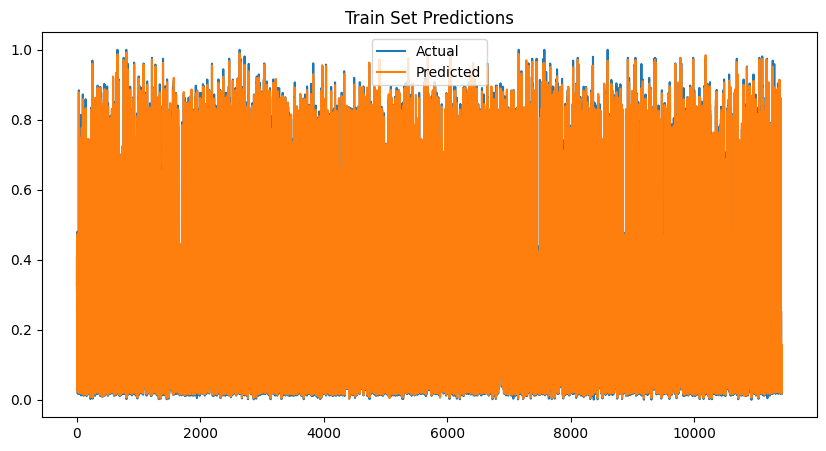

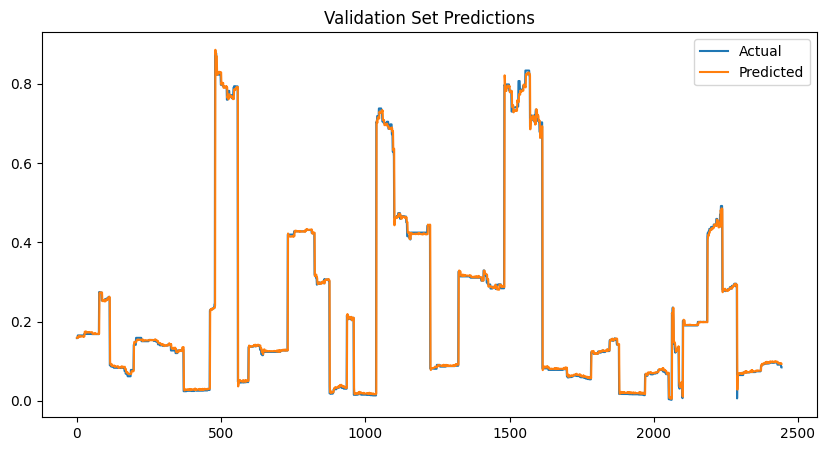

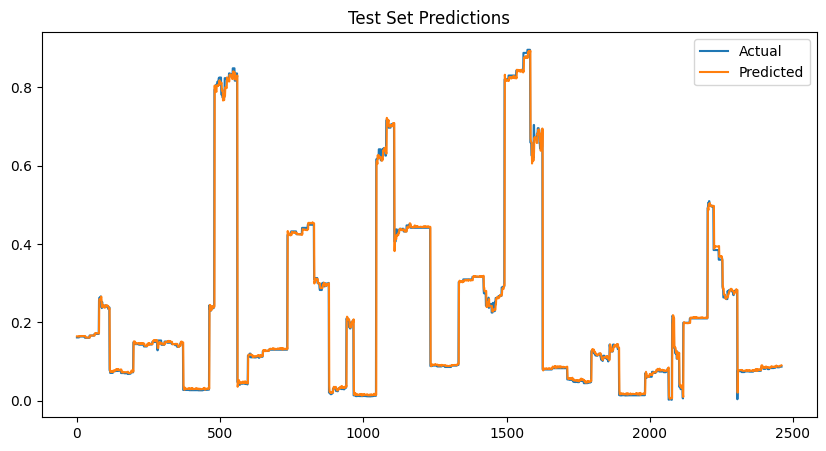

In [ ]:
# -----------------------------
# plot
# -----------------------------
def plot_predictions(preds, trues, title):
    plt.figure(figsize=(10,5))
    plt.plot(trues, label='Actual')
    plt.plot(preds, label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

plot_predictions(train_preds, train_trues, 'Train Set Predictions')
plot_predictions(val_preds, val_trues, 'Validation Set Predictions')
plot_predictions(test_preds, test_trues, 'Test Set Predictions')

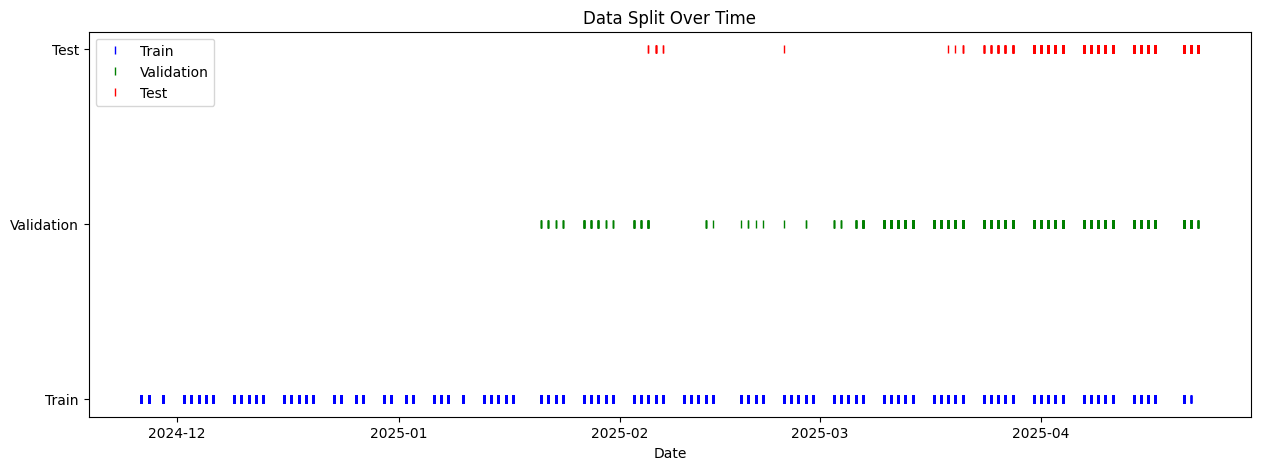

In [ ]:
# -----------------------------
# plot
# -----------------------------
train_dates = train_data['date']
val_dates = val_data['date']
test_dates = test_data['date']

plt.figure(figsize=(15, 5))
plt.plot(train_dates, [1]*len(train_dates), '|', label='Train', color='blue')
plt.plot(val_dates, [2]*len(val_dates), '|', label='Validation', color='green')
plt.plot(test_dates, [3]*len(test_dates), '|', label='Test', color='red')

plt.yticks([1,2,3], ['Train', 'Validation', 'Test'])
plt.xlabel('Date')
plt.title('Data Split Over Time')
plt.legend()
plt.show()